<a href="https://colab.research.google.com/github/StarKill53/Neural-network-basedimage-classifier/blob/main/Neural_network_basedimage_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Star&Galaxies.zip' > /dev/null

In [ ]:
data_dir = 'Star&Galaxies'

batch_size = 32

train_transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomRotation(10), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) 


transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) 

training_data = datasets.ImageFolder(data_dir + '/training', transform=transform)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=transform)
testing_data = datasets.ImageFolder(data_dir + '/testing', transform=transform)

training_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size, shuffle=True)

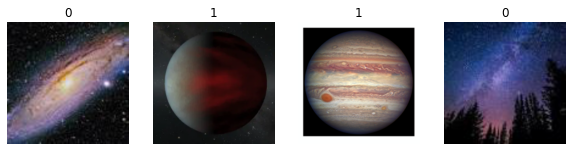

In [ ]:
data_iter = iter(training_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 

In [ ]:
import torch.nn as nn
import torchvision.models as models


model = models.resnet18(pretrained=True)


num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)


if train_on_gpu:
    model.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
n_epochs = 30

valid_loss_min = np.Inf 

train_losses, val_losses = [], []

for epoch in range(n_epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    
   
    model.train() 
    for data, target in training_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)
       
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    
    model.eval() 
    for data, target in validation_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        
        loss = criterion(output, target)
        
        valid_loss += loss.item()*data.size(0)
        
    
    train_loss = train_loss/len(training_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)

    
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') 
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt') 
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.000752 	Validation Loss: 0.026564
Validation loss decreased (inf --> 0.026564).  Saving model ...
Epoch: 2 	Training Loss: 0.000239 	Validation Loss: 0.043706
Epoch: 3 	Training Loss: 0.000086 	Validation Loss: 0.043423
Epoch: 4 	Training Loss: 0.000053 	Validation Loss: 0.033541
Epoch: 5 	Training Loss: 0.000060 	Validation Loss: 0.023914
Validation loss decreased (0.026564 --> 0.023914).  Saving model ...
Epoch: 6 	Training Loss: 0.000081 	Validation Loss: 0.015183
Validation loss decreased (0.023914 --> 0.015183).  Saving model ...
Epoch: 7 	Training Loss: 0.000089 	Validation Loss: 0.009850
Validation loss decreased (0.015183 --> 0.009850).  Saving model ...
Epoch: 8 	Training Loss: 0.000080 	Validation Loss: 0.008017
Validation loss decreased (0.009850 --> 0.008017).  Saving model ...
Epoch: 9 	Training Loss: 0.000065 	Validation Loss: 0.007129
Validation loss decreased (0.008017 --> 0.007129).  Saving model ...
Epoch: 10 	Training Loss: 0.000050 	Valida

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

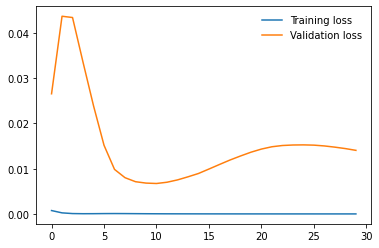

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
model.load_state_dict(torch.load('resnet18_model_fine_tune_aug.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in testing_loader:
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = model(data)
    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)
    
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(testing_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.027599

Test Accuracy of     0: 100% ( 3/ 3)
Test Accuracy of     1: 100% ( 4/ 4)

Test Accuracy (Overall): 100% ( 7/ 7)


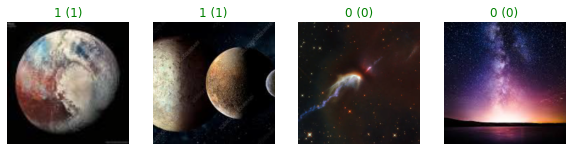

In [ ]:
dataiter = iter(testing_loader)
images, labels = dataiter.next()
images.numpy()


if train_on_gpu:
    images = images.cuda()


output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 
